# Performing Delayed-mode Quality Control on Argo Oxygen Measurements in Python

## Calculate gain and visually QC the data

Using `bgcArgoDMQC`, let's calculate the gain for an oxygen float, visually inspect the data, apply the corrections and then build the delayed mode file that can be uploaded to the GDAC.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import bgcArgoDMQC as bgc

# an NKE ARVOR float operated by Argo Canada, Aanderaa optode 3830
wmo = 4900497 ### NOTE: should choose a float that has in-air data, this one doesn't
# load in the fltthetic file
flt = bgc.sprof(wmo)

# calculate the gains from both sources
air_gains = flt.calc_gains() # reference in NCEP by default, could equivalently call flt.calc_gains(ref='NCEP')
woa_gains = flt.calc_gains(ref='WOA')

### NOTE: this is a lot of not that useful text that gets printed out, supress warnings?


Calculating gains using NCEP surface pressure and float in-air measurements...
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) mis

Now let's plot some things - we will look at the profiles for temperature, salinity, and dissolved oxygen. The core files for this float are already in delayed mode, so we will use the adjusted quantities for temerature and salinity. We want to know if the data pass a visual inspection, and so it is important to know how they are flagged already. The fltthetic profile object, our variable `flt`, has a plot method where various plot types can be made. For the plot described here, we will use the `'qcprofiles'` plot type.

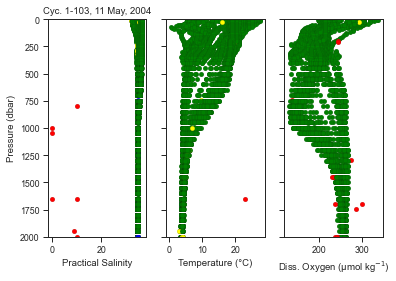

In [2]:
g_qc_profiles = flt.plot('qcprofiles', varlist=['PSAL_ADJUSTED', 'TEMP_ADJUSTED', 'DOXY'])

Now, if we are ok with all data with a QC flag of 4, we may want to more closely inspect the others. We can do this by calling `flt.clean()` which will remove any bad data. If afterwards we wanted to revert to include all data, we could call `flt.reset()`. 

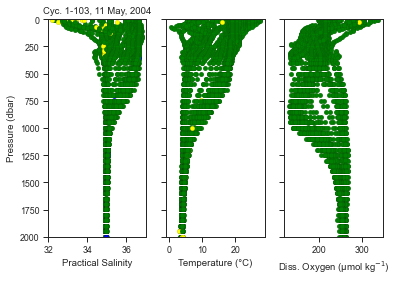

In [3]:
flt.clean()
g_qc_profiles_clean = flt.plot('qcprofiles', varlist=['PSAL_ADJUSTED', 'TEMP_ADJUSTED', 'DOXY'])

Let's also visually inspect the gain values, as outlying gain values can often be a good indicator of potentially erroneous data. This can also be done with `flt.plot()`, where the plot type this time is `'gain'`. We can also specify our reference data source in this function as we did in `flt.calc_gains()`.

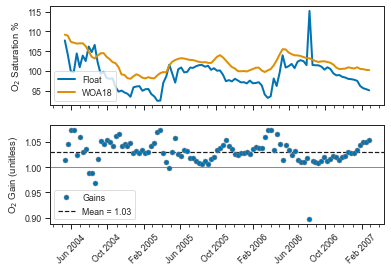

In [4]:
g_gain = flt.plot('gain', ref='WOA')

*note: I am not going to address the erroneous point in the gains here since I will likely change the float, but should show how to safely update data*


Calculating gains using WOA surface data and float O2 percent saturation...


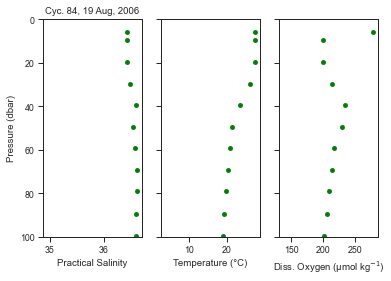

In [5]:
# plot the profile with erroneous data
g_bad_prof = flt.plot('qcprofiles',
    varlist=['PSAL_ADJUSTED', 'TEMP_ADJUSTED', 'DOXY'],
    Nprof=1, Ncycle=flt.CYCLE[woa_gains < 0.95][0]+1)
g_bad_prof.axes[0].set_ylim((100, 0))

### DESIRED FUNCTIONALITY ###
# g_bad_prof = flt.plot_qc_profile(['PSAL_ADJUSTED', 'TEMP_ADJUSTED', 'DOXY'], 
                # cycle=flt.CYCLE[woa_gains < 0.95][0]) # only plot one profile if cycle is specified
# g_bad_prof.axes[0].set_ylim((100, 0))

# update the oxygen where we have a bad value
bad_oxygen = (flt.CYCLE_GRID == flt.CYCLE[woa_gains < 0.95]) & \
    (flt.DOXY > 250) & (flt.PRES < 100)

### DESIRED FUNCTIONALITY ###
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
woa_gains = flt.calc_gains(ref='WOA')

## Populate the adjusted and error fields

In [6]:
# get the mean gain
G = np.nanmean(woa_gains)
flt.update_field('DOXY_ADJUSTED', G*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC == 3)

## Create a D-mode netCDF file

In [12]:
# flt.export_files()
list((flt.__Sprof__.parent / 'profiles').glob('BR*.nc'))

[WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_001.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_002.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_003.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_004.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_005.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_006.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_007.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_008.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_009.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/dac/meds/4900497/profiles/BR4900497_010.nc'),
 WindowsPath('/Users/GordonC/Documents/data/Argo/d